# **Document Image Analysis Pipeline aided by Convolutional Neural Networks to enhance Text-Recognition results**
---


<!-- ### Team Members 

| USN | Name  |
|--|--|
| 1MS19CS082| Neha N Murthy|
|1MS19CS094 |Reesha Shenoy|
|1MS19CS096 |Ritika Kumar|
|1MS19CS129 |Suraj Kumar P| -->


### **Objectives**
- Understand the drawbacks of existing engines
- Propose a pipeline to improve its performance 
- To classify the sections of input images into textual and non textual blocks
- Textual processing on the regions identified
- Exclusively subject regions classified as text to the working of OCR engine


# **Table of Contents**

1. [Imports and Utils](#scrollTo=MvH9F7bTH0A4)

2. [Pre-Processing Pipeline](#scrollTo=dh61XXi1-vfe)

3. [CNN Classifier Model](#scrollTo=H75g60cZAPUF)

4. [Tesseract OCR](#scrollTo=Jg_apuLWBqNT)

5. [Conditioning text blocks for OCR](#scrollTo=bdXfuPH9C6N4)

6. [Refining non-text blocks](#scrollTo=mGRSK3FBDgQC)

7. [Inference](#scrollTo=Rea29qsqEA-s)



# Imports and Utils

In [ ]:
# Mount GDrive
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
DRIVE = '/gdrive/My Drive/Mini Project/'

In [ ]:
# General Imports
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from skimage import filters, measure#, feature, img_as_float
from skimage.draw import polygon_perimeter,polygon
from skimage.morphology import binary_dilation, binary_erosion, dilation, erosion, dilation, closing, opening, area_closing, area_opening, binary_closing
from sklearn import metrics

In [ ]:
 # Plot the image on console using matplotlib
def plot_image(image, title=""):
  plt.imshow(image), plt.title(title, size=14), plt.axis('off')

In [ ]:
# Load image at `path` into memory using skimage.IO
def load_image(path):
  t_img=imread(path)
  return t_img

# Pre-Processing Pipeline

In [ ]:
# binary_erosion, dilation, erosion, dilation, closing, opening, area_closing, area_opening, binary_closing
def marginalization_method1(edges_im):
  x=edges_im
  for i in range(2):
    x=binary_dilation(x)
  for i in range(100):
    x=binary_closing(x)
  for i in range(2):
    x=binary_erosion(x)
  return x

def marginalization_method2(edges_im):
  x=edges_im
  for i in range(7):
    x=binary_dilation(x)
  return x

In [ ]:
# Applies  Graying, Edge detection(Sobel) and binary dilation/erosion
def preprocess_and_morph(im, display=False, method=2):
  
  # Convert to GrayScale
  gray_im = rgb2gray(im)

  # Edge detection using sobel operator
  edges = filters.sobel(gray_im)

  # Enhancing connectivity using morphological operations
  if method==1: 
    morph = marginalization_method1(edges)
  else :
    morph = marginalization_method2(edges)
  
  if display:
    #display stages of the image
    plt.gray()
    plt.figure(figsize=(20,10))
    plt.subplot(1,4,1)
    plot_image(im, 'original')
    plt.subplot(1,4,2)
    plot_image(gray_im, 'gray')
    plt.subplot(1,4,3)
    plot_image(np.clip(edges,0,1), 'sobel')
    plt.subplot(1,4,4)
    plot_image(morph, 'morph')
    plt.show()
  
  print("Morph image generated")
  
  return morph,edges,gray_im


In [ ]:
def generate_countours(morph,edges,display=False):
  contours = measure.find_contours(morph, 0.8)

  # List of contours that meet the threshold
  valid_contours=[]

  fig, ax = plt.subplots()
  if display:
    ax.imshow(edges, cmap=plt.cm.gray)

  for contour in contours:
    # Expand numpy dimensions
    c = np.expand_dims(contour.astype(np.float32), 1)
    # Convert it to UMat object
    c = cv2.UMat(c)
    area = cv2.contourArea(c)
    # ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    if(area>5000):
      valid_contours.append(contour)
      if display:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

  if display:    
    ax.axis('Image')
    # ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()
  
  return valid_contours

In [ ]:
def generate_blocks(im,gray_im,contours):
  # bounding_boxes = []
  gray_blocks=[]
  blocks=[]
  for contour in contours:
      mask = np.ones(gray_im.shape,dtype="bool")
      rr, cc = polygon(contour[:, 0], contour[:, 1])
      mask[rr, cc] = 0
      masked=im.copy()
      masked[mask]=255
      # plot_image(masked)
      Xmin = int(np.min(contour[:,0]))
      Xmax = int(np.max(contour[:,0]))
      Ymin = int(np.min(contour[:,1]))
      Ymax = int(np.max(contour[:,1]))
      # bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
      blocks.append(masked[Xmin:Xmax,Ymin:Ymax])
      gray_blocks.append(masked[Xmin:Xmax,Ymin:Ymax])
  return blocks,gray_blocks


In [ ]:
def display_blocks(blocks,prediction):
  i=0
  plt.figure(figsize=(20,10))
  for im in blocks:
    plt.subplot(len(blocks)/3+1,3,i+1)
    plot_image(im,prediction[i])
    i+=1
  plt.show()

# CNN Classifier Model

> Convolutional Neural Networks specialized for applications in image & video recognition. CNN is mainly used in image analysis tasks like Image recognition, Object detection & Segmentation.

VGG 16

<img src="https://siasky.net/zAAnX2X2-DAVWW8pPt0EibktkLknk4bPdIMxfAdf0WTfVQ" height="300" alt="VGG16"/>

View model training and dataset code [here](https://colab.research.google.com/drive/127ZAKr-X1zKx-JsvKgixqhd73YvE1osX)

In [ ]:
import tensorflow as tf
import cv2 as cv
import numpy as np

model = tf.keras.models.load_model('/gdrive/My Drive/Mini Project/CNN_classifier/DocuParse/DocuParse/docuparser')

In [ ]:
# Use the model to classify [img] as Text or Non-Text
def classify(img):
  img = cv.resize(img, (128, 128),interpolation = cv.INTER_NEAREST)
  img = np.expand_dims(img, axis=0)
  assert img.shape == (1, 128, 128, 3)
  if model.predict(img) > 0.5:
    # plot_image(Image.open(image),"text")
    # return True
    return "text"
  else:
    # plot_image(Image.open(image),'non text')
    # return False
    return "non text"

In [ ]:
# # @title Test the model by specifying a file { display-mode: "form" }
# filepath = '' #@param {type:"string"}

# Tesseract OCR

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pytesseract

def extract_text(image_block):
  return pytesseract.image_to_string(image_block) 

# Conditioning text blocks for OCR

In [ ]:
def prepare_block(block):
  kernel = np.ones((1, 1), np.uint8)
  block = cv2.dilate(block, kernel, iterations=2)
  block = cv2.erode(block, kernel, iterations=2)
  return block

# Refining non-text blocks

In [ ]:
# Future Scope : Can be passed through denoising models to refine non-texual blocks

# Inference

In [ ]:
# from google.colab import files

In [ ]:
# input_file = DRIVE+'Images/Image69.jpg'
input_file = DRIVE+'Images/c24.jpg'

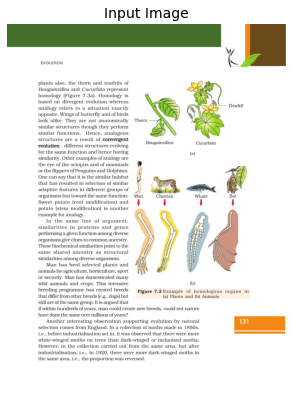

In [ ]:
input_image =load_image(input_file)
plt.figure(figsize=(5,10))

plot_image(input_image,"Input Image")


<Figure size 432x288 with 0 Axes>

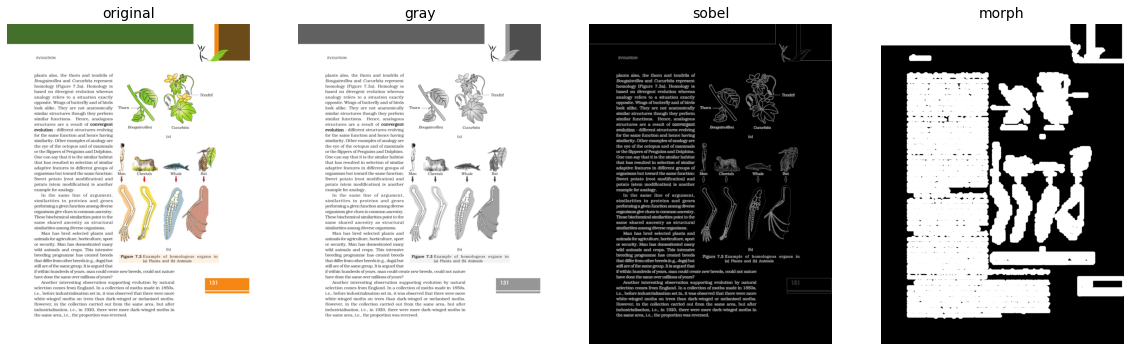

Morph image generated


In [ ]:
display = True #@param {type:"boolean"}
morph_im,edges_im,gray_im = preprocess_and_morph(input_image,display)

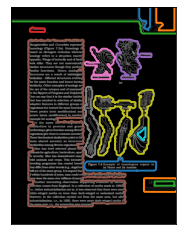

In [ ]:
display = True #@param {type:"boolean"}
contours = generate_countours(morph_im,edges_im,display)

In [ ]:
blocks,gray_blocks=generate_blocks(input_image,gray_im,contours)

In [ ]:
results=[]
for block in gray_blocks:
  results.append(classify(block))

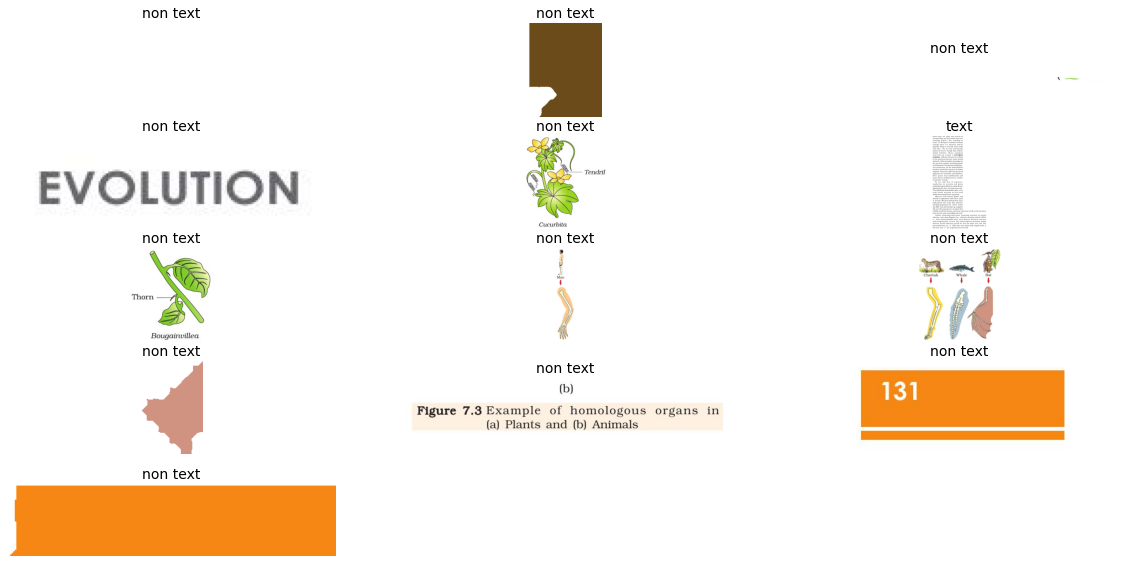

In [ ]:
display = True #@param {type:"boolean"}
if display:
  display_blocks(blocks,results)

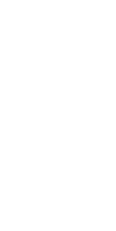


________________



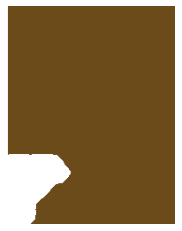


________________



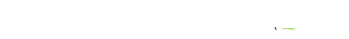


________________



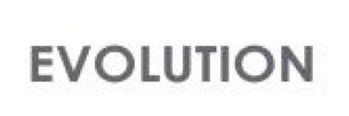


________________



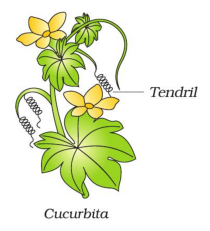


________________

plants also, the thorn and tendrils of
Bougainvillea and Cucurbita represent
homology (Figure 7.3a). Homology is
based on divergent evolution whereas
analogy refers to a situation exactly
opposite. Wings of butterfly and of birds
look alike. They are not anatomically
similar structures though they perform
similar functions. Hence, analogous
structures are a result of convergent
evolution - different structures evolving
for the same function and hence having
similarity. Other examples of analogy are
the eye of the octopus and of mammals
or the flippers of Penguins and Dolphins.
One can say that it is the similar habitat
that has resulted in selection of similar
adaptive features in different groups of
organisms but toward the same function:
Sweet potato (root modification) and
potato (stem modification) is another
example for analogy.

In the same line of argument,
similarities in proteins and genes
performing a given function among diverse
organisms give clues to com

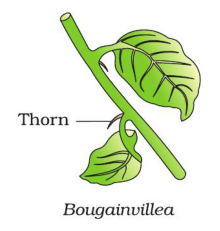


________________



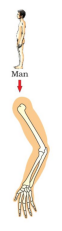


________________



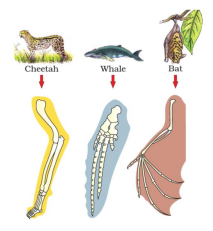


________________



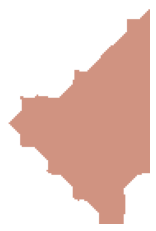


________________



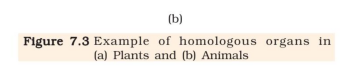


________________



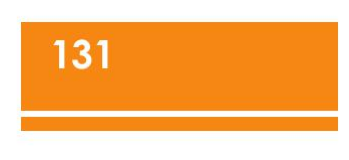


________________



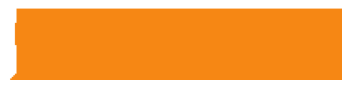


________________



In [ ]:
for i in range(len(blocks)):
  if results[i]=="text":
    extracted_text = extract_text(prepare_block(gray_blocks[i]))
    print(extracted_text)
  else:
    # plt.figure(figsize=(20,10))
    # plt.subplot(len(blocks)/3+1,3,n)
    plot_image(blocks[i])
    # n+=1
  plt.show()
  print("\n________________\n")

In [ ]:
#OCR without our model
extracted_text = extract_text(prepare_block(input_image))
print(extracted_text)

   

EVOLUTION

plants also, the thorn and tendrils of
Bougainvillea and Cucurbita represent

homology (Figure 7.3a). Homology is
based on divergent evolution whereas
analogy refers to a situation exactly
opposite. Wings of butterfly and of birds
look alike. They are not anatomically Thorn
similar structures though they perform
similar functions. Hence, analogous

structures are a result of convergent
evolution - different structures evolving
for the same function and hence having (a)

similarity. Other examples of analogy are

the eye of the octopus and of mammals

or the flippers of Penguins and Dolphins. @
Whale Bat
t t

Bougainvillea Cucurbita

One can say that it is the similar habitat
that has resulted in selection of similar
adaptive features in different groups of
organisms but toward the same function:
Sweet potato (root modification) and
potato (stem modification) is another
example for analogy.

In the same line of argument,
similarities in proteins and genes
performing a gi

# Additional Techniques

### HOG Feature Descriptor

Histogram of Oriented Gradients, also known as HOG, is a feature descriptor like the Canny Edge Detector, SIFT (Scale Invariant and Feature Transform) . It is used in computer vision and image processing for the purpose of object detection.

In [ ]:
#importing required libraries
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
%matplotlib inline

def generate_hog_features(blocks):
  i=1
  list_hog_fd = []
  # list_hog_image=[]
  plt.figure(figsize=(10,30))
  for block in blocks:
    block = resize(block, (128,64))
    fd, hog_image= hog(block, orientations=9, pixels_per_cell=(8,8),cells_per_block=(2, 2), visualize=True)
    list_hog_fd.append(fd)
    # list_hog_image.append(hog_image)

    # Rescale histogram for better display 
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    
    plt.subplot(len(blocks),4,i)
    plot_image(block,f"Input Image ")
    plt.subplot(len(blocks),4,i+1)
    plot_image(hog_image,"HOG")
    i=i+2

  hog_features = np.array(list_hog_fd, 'float64')
  plt.show()
  return hog_features


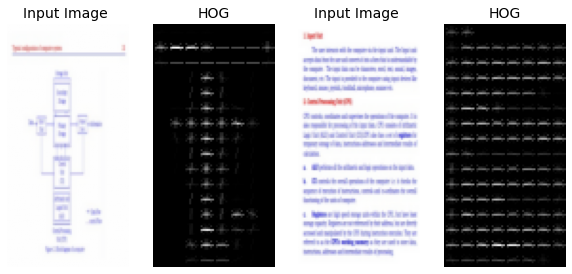

In [ ]:
hog_features = generate_hog_features(blocks)

### Standard ML Classifiers

Commonly used ML Models were also tested for their performance measures when tasked with classifying image blocks as text or non-text.

In [ ]:
# Imports and Utils

import os
import glob
import joblib
from skimage.feature import hog
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def preprocess(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(img, (128,64))#figure out what size we have to rezie the image to
    return image

def extractfeat(path):
    list_hog_fd = []
    # list_hog_image=[]
    for files in os.listdir(path):
        img = preprocess(path + files)
        # print(path + "/" + files)
        fd, hog_image= hog(img, orientations=9, pixels_per_cell=(8,8),
                                cells_per_block=(2, 2), visualize=True)
        # list_hog_image.append(hog_image)
        list_hog_fd.append(fd)
    
    hog_features = np.array(list_hog_fd, 'float64')
    return hog_features

In [ ]:
# Loading the dataset

Text_path = "/gdrive/My Drive/Mini Project/NewOutput/TextDataset/"
Non_Text_path = "/gdrive/My Drive/Mini Project/NewOutput/NonTextDataset/"

print("Extracting text ")
text = extractfeat(Text_path)
print("Extracting non text")
nontext = extractfeat(Non_Text_path)

X = np.vstack((text,nontext))

X = preprocessing.normalize(X)


print("Saving Features....")
np.save("./trainfeat.mat",X)
print("Saved")

trainlabeltext = np.ones(len(os.listdir(Text_path)))
trainlabelnontext = np.zeros(len(os.listdir(Non_Text_path )))
y = np.hstack((trainlabeltext,trainlabelnontext))

Extracting text 
Extracting non text
Saving Features....
Saved


In [ ]:
# Splitting the dataset
trainfeat,testfeat,trainlabel,testlabel= train_test_split(X,y, test_size=0.2, random_state=25)

##### Random Forest Classifier


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfclassifier = RandomForestClassifier(max_depth=15)
rfclassifier.fit(trainfeat, trainlabel)

RandomForestClassifier(max_depth=15)

In [ ]:
print("accuracy on training data: {}".format(rfclassifier.score(trainfeat,trainlabel)))
print("accuracy on test data: {}".format(rfclassifier.score(testfeat,testlabel)))

accuracy on training data: 1.0
accuracy on test data: 0.9239130434782609


##### SVM Classifier


In [ ]:
from sklearn.svm import SVC

svclassifier = SVC(kernel='rbf')
svclassifier.fit(trainfeat, trainlabel)
print("Training Model.....")
y_pred_train = svclassifier.predict(trainfeat)
y_pred_test = svclassifier.predict(testfeat)
print("Done")


Training Model.....
Done


In [ ]:
# print("Training:"+classification_report(trainlabel, y_pred_train))
# print("Testing:"+classification_report(testlabel, y_pred_test))
print("Training:"+str(metrics.accuracy_score(trainlabel, y_pred_train)))
print("Testing:"+str(metrics.accuracy_score(testlabel, y_pred_test)))

Training:0.9959016393442623
Testing:0.9510869565217391


In [ ]:
joblib.dump(svclassifier, './Modelsvm.pkl') 

['./Modelsvm.pkl']

In [ ]:
svclassifier=joblib.load("./Modelsvm.pkl")
# hog_features = np.array(list_hog_fd, 'float64')
# test = preprocessing.normalize(list_hog_fd)
y_pred_test = svclassifier.predict(hog_features)
print(y_pred_test) 

[0. 0.]


#### Multi-layer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(200,))
mlp.fit(trainfeat,trainlabel)
print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
joblib.dump(mlp, './Model.pkl') 

[INFO] Succefully trained the classsifier. 
 Saving the classifier for further use


['./Model.pkl']

In [ ]:
y_pred_train = mlp.predict(trainfeat)
y_pred_test = mlp.predict(testfeat)

In [ ]:
print("Accuracy on training data: {}".format(mlp.score(trainfeat,trainlabel)))
print("Accuracy on test data: {}".format(mlp.score(testfeat,testlabel)))

Accuracy on training data: 1.0
Accuracy on test data: 0.8804347826086957


#### Infering from the Classifiers

In [ ]:
def classification_display(y_pred):
  plt.figure(figsize=(20,10))
  for i in range(0,len(blocks)):
    plt.subplot(4,2,i+1)
    title="text"
    if(y_pred[i]==0):
      title="non text"
    plot_image(blocks[i],title )
    
  plt.show()

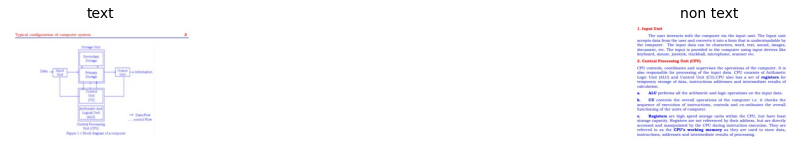

In [ ]:
y_pred_mlp = mlp.predict(hog_features)
classification_display(y_pred_mlp)

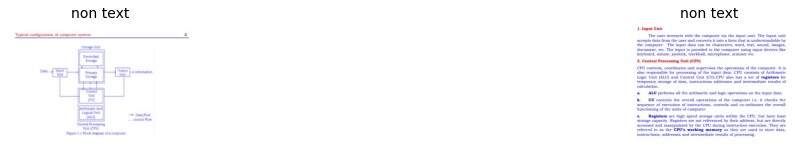

In [ ]:
y_pred_svm=svclassifier.predict(hog_features)
classification_display(y_pred_svm)

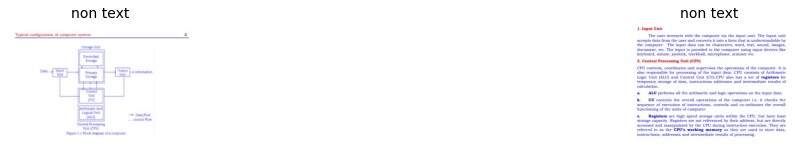

In [ ]:
y_pred_rf=rfclassifier.predict(hog_features)
classification_display(y_pred_rf)

#### Conclusion - ML Classifiers
> While the OCR engine extracts text even from illustrations and outputs them as machine encoded text, with the above provided solution, such situations can be avoided.
